basic loads

In [1]:
from os import listdir, mkdir
from os.path import isfile, join, isdir
from json import loads
from re import findall,UNICODE
import sys
sys.path.append("/Users/andyreagan/tools/python")
from kitchentable.dogtoys import *
from labMTsimple.labMTsimple.speedy import LabMT
my_LabMT = LabMT()
from labMTsimple.labMTsimple.storyLab import *
import numpy as np
import pickle

import os
sys.path.append('/Users/andyreagan/projects/2014/09-books/database')
os.environ.setdefault('DJANGO_SETTINGS_MODULE','gutenbergdb.settings')
import django
django.setup()

from library.models import *
from bookclass import *

from tqdm import tqdm

In [2]:
# all our essentials
from matplotlib import rc,rcParams
# rc('font', family='sans-serif') 
# rc('font', serif='Helvetica Neue')
# rc('text', usetex='false') 

rc('font', family='serif')
rc('font', family='cmr10')
rc('text', usetex='false') 

rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
filters = {"min_dl":40,
           "length": [20000,100000],
           "P": True,
           "n_points": 200,
           "salad": False,
          }
q = get_books(Book,filters)
version_str = get_version_str(filters)
this_dir = join("/Users/andyreagan/projects/2014/09-books/media/figures/SOM",version_str)
if not isdir(this_dir):
    mkdir(this_dir)
big_matrix = get_data(q,version_str,filters,use_cache=True)
big_matrix_mean0 = big_matrix-np.tile(big_matrix.mean(axis=1),(200,1)).transpose()
big_matrix_start0 = big_matrix-np.tile(big_matrix[:,0],(200,1)).transpose()
print(big_matrix.shape)

(1327, 200)


potentially useful 

In [4]:
def mysub2ind(i,n,m):
    # convert the i-th index of a flattened n x m matrix
    # into the i,j of that matrix
    j = int(np.floor(i/float(m)))
    k = i-m*j
    return j,k

In [5]:
def myind2sub(j,k,n,m):
    # convert the [j,k]-th index of an n x m matrix
    # into the i of the flattened matrix
    i = j*n + k
    return int(i)

assert myind2sub(mysub2ind(20,15,15)[0],mysub2ind(20,15,15)[1],15,15) == 20

this is the main function
=========================

In [6]:
# function [B,rmse_all] = train_SOM(A,B,C,numiter,randorder,scaling_fun,nbd_fun,iterstart)
def train_SOM(data,node_states,network_size,numiter,scaling_fun,nbd_fun,randorder=True,iterstart=0,returnDis=False):
    # train an SOM on the data, which is (sample x feature)
    # i.e. books going down, timeseries going across (or PCA
    # coeff across...)
    # INPUTS
    # data: (training pattern i, timeseries j)
    # node_states: initial state of the nodes (num_nodes, features e.g. timeseries length)
    # network_size: tuple of (m,n) size of the network

    num_training_patterns = data.shape[0]
    print(num_training_patterns)
    num_nodes = node_states.shape[0]
    # or, network_size[0]*network_size[1]
    # precompute the distance from each node, to the others
    # this is a distance matrix
    # I'm thinking about this as taking steps on the grid
    # and no torus
    pairwise_distances = np.zeros([num_nodes,num_nodes])
    for i in range(num_nodes):
        for j in range(num_nodes):
            ind1 = mysub2ind(i,network_size[0],network_size[1])
            ind2 = mysub2ind(j,network_size[0],network_size[1])
            pairwise_distances[i,j] = np.abs(ind1[0]-ind2[0])+np.abs(ind1[1]-ind2[1])
    print("pairwise distance:")
    print(pairwise_distances[5,:])
    # plt.figure(figsize=(10,10))
    # plt.imshow(pairwise_distances)
    # plt.title('pairwise distance matrix')
    # mysavefig('SOM-5x5-distanceMatrix.png')
    # plt.show()

    rmse_avg = np.zeros(numiter)

    print('going for {0} iterations now'.format(numiter))
    for i in tqdm(range(iterstart,numiter+iterstart)):
        # print('on training iteration no {0}'.format(i))
        order = np.arange(num_training_patterns)
        # order = np.arange(1)

        if randorder:
            np.random.shuffle(order)

        # go get the scaling parameter
        scaling_coeff = scaling_fun(i)
        # print('scaling coeff is {0}'.format(scaling_coeff))
        
        # print(order)
        for j in order:
            # find the index of the winner
            # print(data[j,:])
            diff = node_states-data[j,:]
            dist = np.sqrt(np.sum(diff**2,axis=(1)))
            # print(dist)
            min_dist = dist.min()
            winning_node = dist.argmin()

            # print('winning node is {0}'.format(winning_node))
            rmse_avg[i-iterstart] += min_dist
            nbd,nbd_coeffs = nbd_fun(i,pairwise_distances[winning_node,:])
            # print('tuning the nbd of size {0}'.format(len(nbd)))
            # print(nbd)
            for n,a in zip(nbd,nbd_coeffs):
                # print(n)
                # print(a.shape)
                # print(node_states[n,:])
                # print(data[j,:].shape)
                # print(node_states[n,:]-data[j,:])
                # print(scaling_coeff)
                # print(a)
                node_states[n,:] = node_states[n,:] - scaling_coeff*a*(node_states[n,:]-data[j,:])
                # print('after:')
                # print(node_states[n,:])

    # here is the MATLAB code for this:
    # % INPUTS
    # %
    # % A(size input,num training patterns)
    # % the training patterns
    # %
    # % B(size input,num nodes in kohonen)
    # % the m_i states of the nodes
    # %
    # % C(num nodes,num nodes)
    # % adjacency matrix for the nodes
    # %
    # % OUTPUT
    # %
    # % B: kohenen matrix values
    # 
    # % how long to train
    # % numiter = 50;
    # % taking this from input
    # 
    # num_training_patterns = length(A(1,:));
    # num_nodes = length(B(1,:));
    # 
    # % rmse_all = ones(num_training_patterns+(1-traintogether)* ...
    # %                 num_training_patterns,numiter);
    # rmse_all = ones(num_training_patterns,numiter);
    # 
    # fprintf('training\n');
    # for i=1+iterstart:numiter+iterstart
    #     fprintf('on training iteration no %f\n',i);
    #     if randorder
    #         order = 1:num_training_patterns;
    #     else
    #         order = randperm(num_training_patterns);
    #     end
    #     scaling_coeff = scaling_fun(i);
    #     fprintf('scaling coeff is %f\n',scaling_coeff);
    #     for j=order
    #         % find the index of the winner
    #         min_dist = sqrt(sum((A(:,j)-B(:,1)).^2));
    #         winning_node = 1;
    #         for k=2:num_nodes
    #             dist = sqrt(sum((A(:,j)-B(:,k)).^2));
    #             if dist<min_dist
    #                 min_dist = dist;
    #                 winning_node = k;
    #             end
    #         end
    #         % fprintf('winning node is %f\n',winning_node);
    #         rmse_all(j,i-iterstart) = min_dist;
    #         [nbd,nbd_coeffs] = nbd_fun(i,winning_node,C);
    #         % fprintf('tuning the nbd of size %f\n',length(nbd))
    #         for k=1:length(nbd)
    #             B(:,nbd(k)) = B(:,nbd(k)) - scaling_coeff*nbd_coeffs(k)*(B(:,nbd(k))-A(:,j));
    #         end
    #     end
    #     % rmse_avg(1,i) = mean(rmse_all(:,i));
    # end
    # I'm not going to need an adjacency matrix...I'm just going to go for a simpler grid model
    
    if returnDis:
        return node_states,rmse_avg,pairwise_distances
    else:
        return node_states,rmse_avg

In [7]:
# define some quick functions for the scalings
def scaling_fun_alpha(i,alpha):
    return np.power(i+1,alpha)

def nbd_fun_alpha(iteration,distance_list,alpha):
    tmp = np.arange(distance_list.shape[0])
    tmp2 = np.ones(distance_list.shape[0])
    max_d = network_size[0]*np.power(iteration+1,alpha)
    # max_d = 3.0
    return tmp[distance_list < max_d],tmp2[distance_list < max_d]

In [8]:
def RMSE(a,b):
    return np.sqrt(np.sum(np.power((a-b),2)))

def plot_B_matrix(trained_nodes,network_size,cmap="Greys",d=RMSE,shrink=.7):
    # plot the B-matrix
    B = np.zeros(np.array(network_size)*2-1)
    # march across and fill out this bad boy
    # entries at the nodes are the mean distance to all neighbors
    # entries inbetween are, inbetween (or the mean of two inbetweens)

    # go down on the ones with nodes
    # these are the betweens horizontally
    
    # going to replace RMSE with my own distance metric
    for j in np.arange(0,B.shape[0],dtype=int): # down
        for i in np.arange(0,B.shape[1],dtype=int): # across
            if not np.mod(j,2) and not np.mod(i,2): # if both even
                B[j,i] = 0
            if np.mod(j,2) and not np.mod(i,2): # if down odd, across even
                up = trained_nodes[myind2sub((j-1)/2,i/2,network_size[0],network_size[1]),:]
                down = trained_nodes[myind2sub((j+1)/2,i/2,network_size[0],network_size[1]),:]
                B[j,i] = d(up,down)
            if not np.mod(j,2) and np.mod(i,2): # if down even, across odd
                left = trained_nodes[myind2sub(j/2,(i-1)/2,network_size[0],network_size[1]),:]
                right = trained_nodes[myind2sub(j/2,(i+1)/2,network_size[0],network_size[1]),:]
                B[j,i] = d(left,right)
            if np.mod(j,2) and np.mod(i,2): # if down odd, across odd
                upleft = trained_nodes[myind2sub((j-1)/2,(i-1)/2,network_size[0],network_size[1]),:]
                downleft = trained_nodes[myind2sub((j+1)/2,(i-1)/2,network_size[0],network_size[1]),:]
                upright = trained_nodes[myind2sub((j-1)/2,(i+1)/2,network_size[0],network_size[1]),:]
                downright = trained_nodes[myind2sub((j+1)/2,(i+1)/2,network_size[0],network_size[1]),:]
                B[j,i] = (d(up,down)+d(left,right))/2
    # print(B)
    plt.imshow(B, aspect=1, cmap=plt.get_cmap(cmap), origin='lower', interpolation='nearest', extent=(-0.25,network_size[0]-0.75,-0.25,network_size[1]-0.75))
    plt.colorbar(shrink=shrink)
    # mysavefig('SOM-Animals-{0}x{0}-U-Matrix.png'.format(network_size[0]))
    # plt.show()

now do this for the book data
================

In [132]:
# start with 20x20
# network_size = (18,18)
# network_size = (13,13)
# network_size=(8,8)
# network_size=(4,4)
network_size = (2,3)
num_nodes = network_size[0]*network_size[1]
node_states = np.random.randn(num_nodes,big_matrix.shape[1])*.05

# define some quick functions for the scalings
def scaling_fun_alpha(i,alpha):
    return np.power(i+1,alpha)

def nbd_fun_alpha(iteration,distance_list,alpha):
    tmp = np.arange(distance_list.shape[0])
    tmp2 = np.ones(distance_list.shape[0])
    max_d = np.sqrt(num_nodes)*np.power(iteration+1,alpha)
    # max_d = 3.0
    return tmp[distance_list < max_d],tmp2[distance_list < max_d]

iterations = 500
trained_nodes,rmse = train_SOM(big_matrix_mean0,
                               node_states,
                               network_size,
                               iterations,
                               lambda x: scaling_fun_alpha(x,-0.10),
                               lambda x,y: nbd_fun_alpha(x,y,-0.15))
    
# print(trained_nodes)
# print(rmse)

100%|██████████| 500/500 [00:33<00:00, 18.39it/s]

1327
pairwise distance:
[ 3.  2.  1.  2.  1.  0.]
going for 500 iterations now


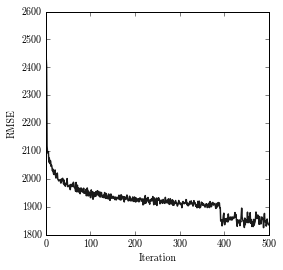

In [133]:
plt.figure(figsize=(4,4))
plt.plot(range(iterations),rmse,".1",linewidth=1.5)
# plt.title('SOM RMSE')
plt.xlabel("Iteration")
plt.ylabel("RMSE")
mysavefig('SOM-{0}x{0}-RMSE.pdf'.format(network_size[0]),folder=this_dir)

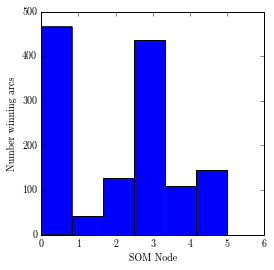

In [134]:
data = big_matrix
winning_node_list = np.zeros(data.shape[0])
for j in range(data.shape[0]):
    diff = trained_nodes-data[j,:]
    dist = np.sqrt(np.sum(diff**2,axis=(1)))
    winning_node_list[j] = dist.argmin()
plt.figure(figsize=(4,4))
n,bins,patches = plt.hist(winning_node_list,bins=num_nodes)
# plt.title('SOM Winning Nodes')
plt.xlabel("SOM Node")
plt.ylabel("Number winning arcs")
mysavefig('SOM-{0}x{0}-node-hist.pdf'.format(network_size[0]),folder=this_dir)

In [135]:
# now let's also plot them
def plot_clusters(clusters,data,cluster_centers,cluster_id,v=True,fix_ylim=True,xspacing=.01,investigate=False,save=True):
    # we are going to make plots of max width 3
    num_x = np.min([3,len(clusters)])
    num_y = np.ceil(len(clusters)/num_x)
    xspacing = .03
    yspacing = .03
    xoffset = .07
    yoffset = .07
    xwidth = (1.-xoffset)/(num_x)-xspacing
    yheight = (1.-yoffset)/(num_y)-yspacing
    print('xwidth is {0}'.format(xwidth))
    print('yheight is {0}'.format(yheight))
    
    # go compute the ybounds:
    calc_ylim = [100.0,-100.0]
    for cluster in clusters:
        c_max = data[cluster[0][:20],:].max()
        c_min = data[cluster[0][:20],:].min()
        calc_ylim[0] = np.min([calc_ylim[0],c_min])
        calc_ylim[1] = np.max([calc_ylim[1],c_max])
        
    chars = 60
    
    scale_factor_x = 5
    scale_factor_y = 5*1.25
    if investigate:
        scale_factor_x = 10
        scale_factor_y = 10*1.25
    fig = plt.figure(figsize=(scale_factor_x*num_x,scale_factor_y*num_y))
    for i,cluster in enumerate(clusters):
        print(i)
        print("====")
        # print((i-i%num_x))
        # ind = np.argsort(w[:,sv+svstart])[-20:]
        ax1rect = [xoffset+(i%num_x)*(xspacing+xwidth),1.-yheight-yspacing-(int(np.floor((i-i%num_x)/num_x))*(yspacing+yheight))+yheight*.2,xwidth,yheight*.8]
        ax1 = fig.add_axes(ax1rect)
        ax1books_rect = ax1rect.copy()
        ax1books_rect[1] -= yheight*.2
        ax1books_rect[3] = yheight*.2
        ax1books = fig.add_axes(ax1books_rect)
        # ax1books.text?
        # ax.set_title('20 closest positive correlates')
        
        if v:
            print('-'*80)
            print('20 closest positive correlates:')
            # print(cluster)
        j=0
        for index,title in zip(*cluster):
            if j+1 > 20:
                break
            if investigate:
                ax1.plot(data[index],label="{} ({})".format(title,q[int(index)].gutenberg_id))
            else:
                ax1.plot(data[index],color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(index,title)
            if j<5:
                ax1books.text(0.0,.8-j*.2,"{} ({})".format(title,q[int(index)].gutenberg_id),fontsize=10)
            j+=1
        ax1.plot(cluster_centers[cluster_id[i]],color="#ff6700",linewidth=2,label="Node {} Cluster {} ({})".format(cluster_id[i],i+1,len(cluster[0])))
        # ax1.set_xticklabels([])
        ax1.legend(loc="upper right")

        # ax1.axis('off')
        ax1books.axis('off')
        
        props = dict(boxstyle='square', facecolor='white', alpha=1.0)
        # fig.text(ax1rect[0]+.03/xwidth, ax1rect[1]+ax1rect[3]-.03/yheight, letters[i],
        if fix_ylim:
            my_ylim = calc_ylim
        else:
            my_ylim = ax1.get_ylim()
        ax1.text(.035*200, my_ylim[0]+.965*(my_ylim[1]-my_ylim[0]), letters[i],
                     fontsize=14,
                     verticalalignment='top',
                     horizontalalignment='left',
                     bbox=props)

        if fix_ylim:
            ax1.set_ylim(calc_ylim)
        if fix_ylim and i%num_x > 0:
            ax1.set_yticklabels([])
        if True: # i<num_x*(num_y-1): # only on the bottom row
            ax1.set_xticklabels([])
            
    if save:
        # mysavefig('SV{0}.svg'.format('4-6'))
        mysavefig("clustered-timeseries.pdf".format(),
                  folder=this_dir,
                  openfig=True)

In [136]:
allDistances = pickle.load(open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-matrix-cache-{}.p".format(version_str),"rb"))
allDistancesCentered = pickle.load(open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-mean0-matrix-cache-{}.p".format(version_str),"rb"))
allDistancesStart = pickle.load(open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-start0-matrix-cache-{}.p".format(version_str),"rb"))

In [137]:
def cityBlock(a,b):
    return np.sum(np.abs(a-b))

def get_sorted(all_ind,center=[]):
    if len(center) ==  0:
        # go get the submatrix
        # allDistances[[1,2,3],:][:,[1,2,3]]
        submat = allDistances[all_ind,:][:,all_ind]
        # print(submat)
        distances = submat.sum(axis=0)
    else:
        # ---------
        # that did distance from the other stories...
        # let's look at distance from the SOM story?
        distances = [cityBlock(center,big_matrix_mean0[all_ind[i],:]) for i in all_ind]
    
    # print(distances)
    indices_sorted = sorted(range(len(all_ind)),key=lambda i: distances[i])
    all_ind_sorted = all_ind[indices_sorted]
    distances_sorted = distances[indices_sorted]
    # print(all_ind_sorted)
    # make sure they're sorted the right way!
    # print(distances_sorted)
    assert distances_sorted[0] < distances_sorted[1]
    titles_sorted = ["" for i in range(len(all_ind_sorted))]
    chars = 50
    for i,ind in enumerate(all_ind_sorted):
        b = q[int(ind)]
        if len(b.title) > chars:
            titles_sorted[i] = "{}. {}...".format(i+1,b.title[:chars-3].replace("\n",": ").replace("&","\&"))
        else:
            titles_sorted[i] = "{}. {}".format(i+1,b.title.replace("\n",": ").replace("&","\&"))
    return all_ind_sorted,titles_sorted

In [138]:
# let's look at what we have to build the data to plot. here are the trained nodes:

In [139]:
trained_nodes.shape

(6, 200)

In [140]:
winning_node_list.shape
# looks like a list of the winning node for each story

(1327,)

In [141]:
winning_node_list[:10]
# peek at the winning nodes

array([ 0.,  0.,  3.,  0.,  0.,  0.,  0.,  5.,  4.,  2.])

In [142]:
n
# this is binned onto each node index by plt.hist() (count of wins by node)

array([ 466.,   43.,  127.,  436.,  110.,  145.])

In [143]:
len(n)
# make sure I have 100 bins

6

In [144]:
# must have done a 10x10!
# let's rebuild n anyway
n_nodes = [np.nonzero(winning_node_list==i)[0] for i in range(num_nodes)]
print(n_nodes)
n = list(map(len,n_nodes))
print(n)

[array([   0,    1,    3,    4,    5,    6,   13,   19,   26,   30,   31,
         44,   45,   48,   49,   51,   55,   58,   59,   61,   62,   66,
         68,   74,   78,   79,   83,   84,   87,   92,   93,   95,   96,
         97,   98,  101,  104,  109,  114,  115,  118,  121,  122,  127,
        129,  130,  133,  137,  141,  144,  145,  151,  154,  157,  160,
        164,  169,  170,  172,  177,  180,  181,  185,  189,  194,  202,
        204,  208,  209,  211,  212,  214,  215,  219,  222,  223,  226,
        227,  230,  231,  232,  239,  242,  246,  247,  254,  255,  259,
        261,  263,  265,  266,  267,  268,  272,  277,  279,  289,  291,
        297,  299,  301,  305,  306,  307,  308,  311,  313,  314,  315,
        317,  318,  319,  320,  326,  330,  332,  333,  340,  349,  354,
        356,  359,  362,  364,  367,  369,  370,  372,  376,  377,  381,
        382,  383,  384,  386,  389,  391,  401,  402,  409,  411,  412,
        417,  418,  422,  423,  424,  427,  428,  

In [145]:
n_indexer = sorted(range(len(n)),key=lambda i: n[i],reverse=True)
# let's sort the winning nodes
print(n_indexer)

[0, 3, 5, 2, 4, 1]


In [146]:
n_sorted = [n[n_i] for n_i in n_indexer]

In [147]:
n_sorted[:9]
# okay, now we have sorted counts

[466, 436, 145, 127, 110, 43]

In [148]:
n_indexer[:9]
# and the sorted nodes

[0, 3, 5, 2, 4, 1]

In [149]:
winning_node_list==n_indexer[0]
# these are the stories that match winning node 1

array([ True,  True, False, ..., False, False, False], dtype=bool)

In [150]:
np.nonzero(winning_node_list==82)
# here are their indices

(array([], dtype=int64),)

In [151]:
len(np.nonzero(winning_node_list==82)[0])
# and BOOM there are 59 of them

0

In [152]:
clusters = [get_sorted(n_nodes[n_i]) for n_i in n_indexer[:9]]
# clusters = []

xwidth is 0.28
yheight is 0.43499999999999994
0
====
1
====
2
====
3
====
4
====
5
====


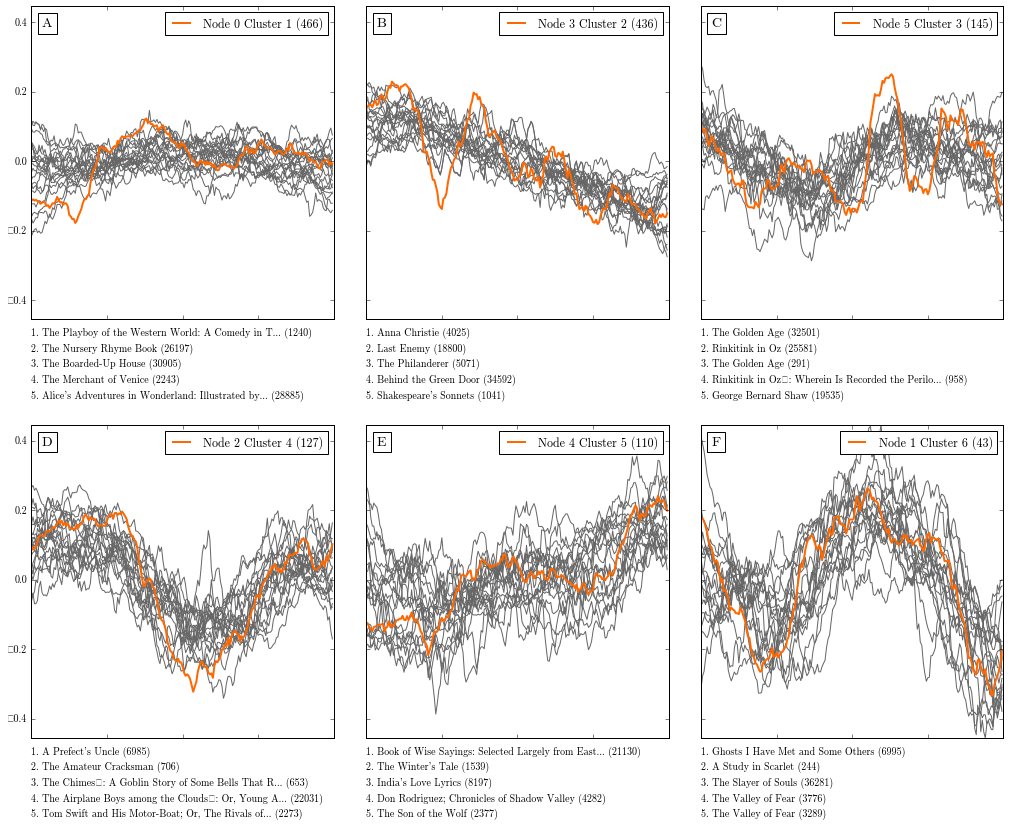

In [153]:
plot_clusters(clusters,big_matrix_mean0,trained_nodes,n_indexer,v=False,fix_ylim=True,xspacing=.01,investigate=False,save=True)

In [120]:
cityBlock(trained_nodes[n_indexer[1],:],trained_nodes[n_indexer[2],:])

7.9371172471279854

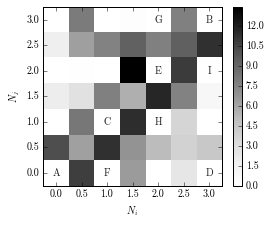

In [121]:

plt.figure(figsize=(4,4))

plot_B_matrix(trained_nodes,network_size,cmap="Greys",d=cityBlock,shrink=.8)
for i in range(9):
    if i==0:
        color=".1"
    else:
        color=".1"
    plt.text(mysub2ind(n_indexer[i],network_size[0],network_size[0])[1],
             mysub2ind(n_indexer[i],network_size[0],network_size[0])[0],
             letters[i],
             ha="center",
             va="center",
             fontsize=10,
             color=color)
plt.xlabel("$N_i$")
plt.ylabel("$N_j$")

mysavefig("Bmatrix-labeled.pdf",folder=this_dir,openfig=True,)


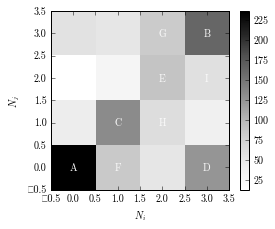

In [122]:
plt.figure(figsize=(4,4))

plt.imshow(np.reshape(n,network_size), aspect=1, cmap=plt.get_cmap('Greys'), origin='lower', interpolation='nearest', ) #extent=(-0.25,network_size[0]-0.75,-0.25,network_size[1]-0.75))
plt.colorbar(shrink=.8)
plt.xlim()
for i in range(9):
    if i==0:
        color=".99"
    else:
        color=".99"
    plt.text(mysub2ind(n_indexer[i],network_size[0],network_size[0])[1],
             mysub2ind(n_indexer[i],network_size[0],network_size[0])[0],
             letters[i],
             ha="center",
             va="center",
             fontsize=10,
             color=color)
    
plt.xlabel("$N_i$")
plt.ylabel("$N_j$")


mysavefig("heatmap-labeled.pdf",folder=this_dir,openfig=True)

In [123]:
import subprocess
cmd = "/Users/andyreagan/tools/shell/2015-08-kitchentabletools/pdftile.pl 1 2 0.48 3 0 l 8 \"\" \"\" {0}/Bmatrix-labeled.pdf \"\" {0}/heatmap-labeled.pdf {0}/SOM-matrices".format(this_dir)
# ~/tools/shell/2015-08-kitchentabletools/pdftile.pl 1 3 0.3 3 0 l 8 "" "" 2016-03-11-15-10-training.pdf "" 2016-03-11-15-13-Bmatrix-labeled.pdf "" 2016-03-11-15-14-heatmap-labeled.pdf SOM
subprocess.call(cmd,shell=True)

127

In [124]:
n_sorted[:40]

[236, 162, 133, 125, 89, 84, 82, 63, 60, 58, 53, 53, 45, 40, 31, 13]

In [125]:
n_sorted

[236, 162, 133, 125, 89, 84, 82, 63, 60, 58, 53, 53, 45, 40, 31, 13]

<Container object of 16 artists>

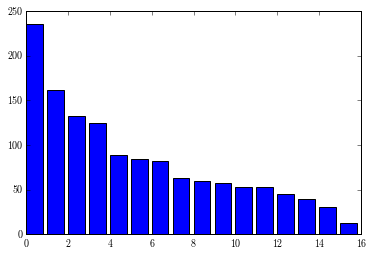

In [126]:
plt.bar(range(len(n_sorted)),n_sorted)

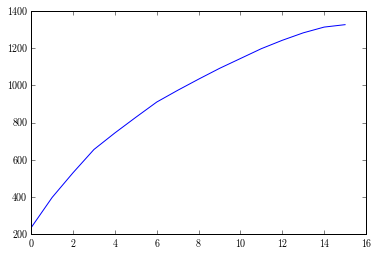

In [127]:
plt.plot(range(len(n_sorted)),np.cumsum(n_sorted))

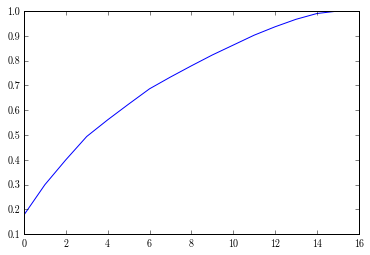

In [128]:
plt.plot(range(len(n_sorted)),np.cumsum(n_sorted)/len(q))

In [130]:
np.arange(len(n_sorted))[np.cumsum(n_sorted)/len(q) > .85][0]

10

need that many above to make 85% of the stories

wouldn't expect that they all need to collapse onto one, though

but the decay is pretty steadyn (not sharp), so many nodes needed